In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

# 1 EDA
Загрузите датасет с резюме программистов и проведите предварительный анализ
данных. Включите в анализ следующие шаги:

a. Ознакомьтесь с общей структурой и содержанием данных.

b. Проверьте наличие пропущенных значений и решите, как с ними работать.

c. Изучите распределение данных в различных атрибутах (например, опыт работы,
образование и т.д.

In [ ]:
df = pd.read_csv('/content/cv_programmers.csv', encoding = 'windows-1251')

## А - Значения и их количество по столбцам

In [194]:
df.dtypes

Unnamed: 0                         int64
id                                object
abilympics_inspection_status      object
abilympics_participation            bool
worldskills_inspection_status     object
state_region_code                  int64
regionNameTerm                   float64
position_name                     object
date_create                       object
date_modify                       object
home_city_code                     int64
education                         object
academic_degree                  float64
drive_license                     object
code_country                      object
nark_inspection_status            object
nark_certificate                  object
published_date                    object
schedule_type                     object
experience                         int64
salary                             int64
professional_skills               object
add_skills                        object
busy_type                         object
business_trip   

## В - Количество пропусков по столбцам



In [ ]:
df.isna().sum()

Unnamed: 0                         0
id                                 0
abilympics_inspection_status       0
abilympics_participation           0
worldskills_inspection_status      0
state_region_code                  0
regionNameTerm                   425
position_name                      0
date_create                        0
date_modify                        0
home_city_code                     0
education                         58
academic_degree                  425
drive_license                    352
code_country                       0
nark_inspection_status             0
nark_certificate                 420
published_date                     4
schedule_type                      0
experience                         0
salary                             0
professional_skills              397
add_skills                       405
busy_type                          0
business_trip                      0
id_candidate                       0
other_certificates               388
r

## C - рапределения данных

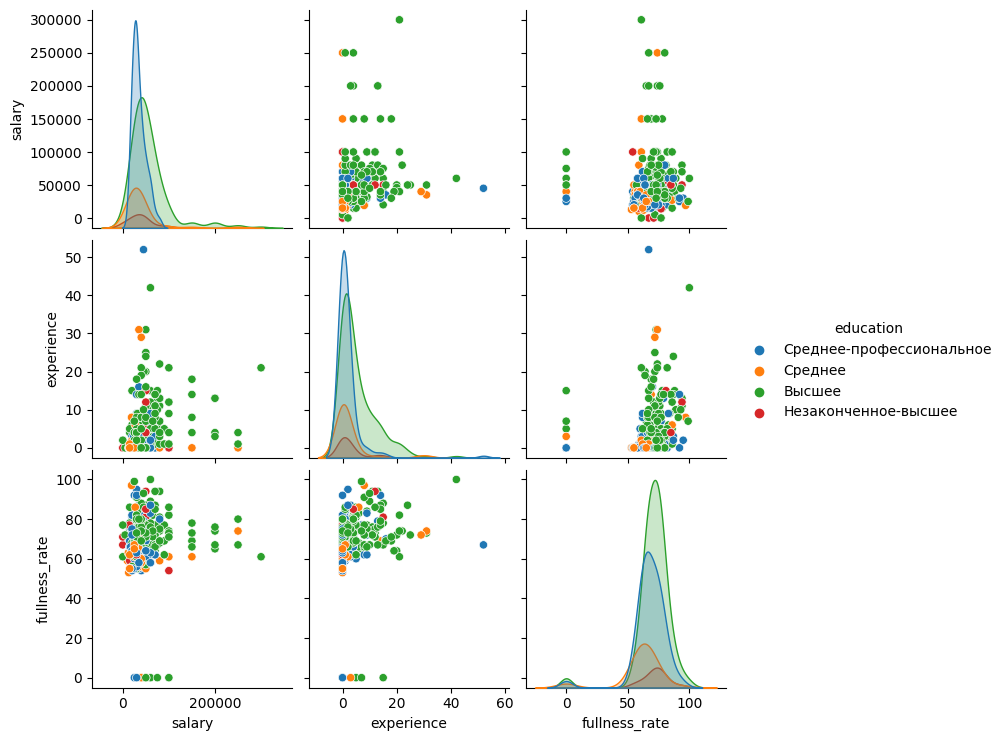

In [ ]:
sel_columns = ['salary', 'experience', 'fullness_rate', "education"]
sns.pairplot(df[sel_columns], hue="education")

# 2 предобработка данных
Проведите предобработку данных:

a. Примените необходимые методы для обработки пропущенных значений.

b. Создайте новые признаки (при необходимости).

предложенный датасет не обработанный, поэтому будет принято решение по столбцам:
* удалить:
 - у которых пропусков > 90%
 - с ненужной информацией (id, date, etc...)
 - с дизбалансом класса
* изменить:
 - столбцы, которые можно интепреетировать как бинарные величину (есть/нет)
 - количественно посчитать (образование, работу)

Предобработка датасета

In [ ]:
def get_from_json(json_file: str, field: str) -> tuple:
  # function for get data from json
  res = []
  json_array = json.loads(json_file)
  for i in range(len(json_array)):
    res.append(json_array[i].get(field))
  return tuple(res)

In [ ]:
# read csv
df = pd.read_csv('/content/cv_programmers.csv', encoding = 'windows-1251')

list_for_drops_columns = ['Unnamed: 0', 'id', 'id_candidate',
                          'id_user','date_create','date_modify',
                          'published_date', 'contactList',
                          'other_info','home_city_code','state_region_code',
                           'schedule_type',]
df.drop(list_for_drops_columns, axis = 1, inplace=True) # delete rows id
df.dropna(thresh=df.shape[0]*0.2, axis=1, inplace = True) # delete rows where nan > 80%

# binary features
list_bin_col = ['desirableRelocationRegions', 'drive_license', 'hardSkills', 'softSkills']
for col in list_bin_col:
  df[col] = df[col].apply(lambda x: 1 if x != '[]' else 0)

# binary feature - from big city
big_city = 'Москва|Санкт-Петербург|Краснодар|Ростов-на-Дону|Казань|Новосибирск'
df['localityName'] = np.where(df['localityName'].str.contains(big_city), 1, 0)

# take 10 frequence prof, rest set 'other'
df['professionList'] = df['professionList'].apply(
    lambda x: " ".join(get_from_json(x, 'code_professional_sphere')) if x != '[]' else np.nan)
top_10_prof = tuple(df["professionList"].value_counts().head(10).index)
df['professionList'] = np.where(df['professionList'].isin(top_10_prof), df['professionList'], 'other')

# number foreign languages
z = set(['Русский', 'Чеченский','Тувинский',
         'Таджикский', 'Якутский', 'Осетинский',
         'Азербайджанский', 'Татарский', 'Башкирский'])
df['languageKnowledge'] =  df['languageKnowledge'].apply(lambda x:
                              len([y for y in get_from_json(x, 'code_language') if y not in z])
                              if x != '[]'
                              else 0)
# quantitative features
list_number_feature = ['educationList', 'additionalEducationList', 'workExperienceList']
for col in list_number_feature:
  df[col] = df[col].apply(lambda y: 0 if y == '[]' else len(json.loads(y)))

# rough clear column position_name
df['position_name'] = df['position_name'].str.lower()
dic = {
    'web|веб|сайт|front':'web',
    '1c|1с': '1c',
    'python': 'python',
    'java': 'java',
    'сист': 'devops',
    'начинающий|младший|junior|стажёр|стажер' : 'junior',
    'инженер': 'engineer'
}
for k, v in dic.items():
    df['position_name'] = np.where(df['position_name'].str.contains(k), v, df['position_name'])
# take 10 frequence position, rest set 'other'
top_10_pos = tuple(df["position_name"].value_counts().head(10).index)
df['position_name'] = np.where(df['position_name'].isin(top_10_pos), df['position_name'], 'other')

# rename columns
df.rename({'workExperienceList': 'n_work',
           'additionalEducationList': 'n_courses',
           'educationList': 'n_education',
           'languageKnowledge': 'n_foreign_languages',
           'hardSkills': 'filled_hardSkills',
           'softSkills': 'filled_softSkills',
           'localityName': 'big_city',
           'drive_license': 'have_drive_license',
           'desirableRelocationRegions': 'relocate',
           }, axis=1, inplace=True)

Уберем людей, у которых маленький опыт, но просят много деняг.

Если в salary указана желаемая зарплата в рублях, то убрать кандидатов с зарплатой меньше мрот.

In [ ]:
df.drop(df[df['salary'] <=10000].index, inplace = True)
df.drop(df[(df['salary'] >=200000) & (df['experience'] <= 1)].index, inplace = True)

In [ ]:
# Printing information on the dataset
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')
print('- -' * 30)
print('Value counts for each columns: \n')
for i in df.columns:
    if df[i].isnull().sum() == df.shape[0]:
      print(f'droped empty column == {i}')
      df.drop(i, axis = 1, inplace=True)
      continue
    elif df[i].nunique() == 1:
      print(f'droped column with solo variable == {i}')
      df.drop(i, axis = 1, inplace=True)
      continue
    elif (df[i].value_counts().max() / df.shape[0]) > 0.98:
      print(f'droped column with disbalanced variables == {i}')
      df.drop(i, axis = 1, inplace=True)
      continue

    print(f'===== {i}=====\n')
    print(df[i].value_counts().sort_values(ascending=False))
    print('- -' * 30)

The dataset has 415 rows and 29 columns

- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
Value counts for each columns: 

droped column with solo variable == abilympics_inspection_status
droped column with disbalanced variables == abilympics_participation
droped column with disbalanced variables == worldskills_inspection_status
===== position_name=====

программист                223
other                       41
engineer                    40
1c                          27
junior                      21
техник-программист          20
web                         18
devops                      12
python                       6
java                         5
программист,-специалист      2
Name: position_name, dtype: int64
- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -
===== education=====

Высшее                      174
Среднее-профессиональное    126
Среднее                      44
Незаконченное-выс

количество пропущенных значений

In [ ]:
df[df.columns[df.isnull().any()]].isnull().sum()

education    56
dtype: int64

## восстановим пропущенные значения education и подготовим данные для модели

In [ ]:
# label and one-hot encoding
le = LabelEncoder()
one_hot_column = ['busy_type','position_name','professionList']
bin_column = ['business_trip', 'retraining_capability']

df[bin_column] = df[bin_column].apply(le.fit_transform)
df = pd.get_dummies(df, columns = one_hot_column)

In [ ]:
df_miss_education = df[df['education'].isna()]
df_with_education = df[~df['education'].isna()]

In [ ]:
X = df_with_education.drop(columns='education',axis=1)
y = le.fit_transform(df_with_education['education'])

model = RandomForestClassifier().fit(X, y)
y_edu = model.predict(df_miss_education.drop(columns='education', axis=1))

df_miss_education['education'] = le.inverse_transform(y_edu)

df = pd.concat([df_with_education, df_miss_education])

<ipython-input-167-eccd46edc9c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_miss_education['education'] = le.inverse_transform(y_edu)


In [ ]:
df = pd.get_dummies(df, columns = ['education'])#one-hot

In [ ]:
print(f'количество пропусков = {df.isna().sum().sum()}')

количество пропусков = 0


# 3 Прогнозирование

Прогнозирование:

Создайте модель прогнозирования, которая будет предсказать уровень желаемой зарплаты (столбец salary в датасет)

Будем решать задачу регрессии. Для нее выбрана модель random forest

Плюсы случайного леса:
* Практически не чувствителен к выбросам в данных
* Редко переобучается
* Параллелизуемость и масштабируемость

In [ ]:
X = df.drop(columns='salary',axis=1)
y = df['salary']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=27)

rf = RandomForestRegressor().fit(X_train, y_train)

# 4 Анализ полученных результатов




## A - Оцените качество модели машинного обучения по выбранным метрикам

Использовать RMSE для оценки модели на выборках с выбросами может быть неудобно, поэтому использована  MAE

MAE - это оценочная величина абсолютного отклонения между целевым и прогнозируемым значениями.

MAPE - средняя разница между прогнозируемым значением и фактическим значением.

* Чем ближе метрики MAPE и MAE к нулю, тем лучше.

In [ ]:
# evaluate the model
y_pred = rf.predict(X_test)
# evaluate predictions
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'mae = {mae}')
print(f'mape = {mape}')

mae = 19448.656419965577
mape = 0.44815313143359264





в данном случае MAPE около 45%

* Для улучшения метрик модели можно применить поиск гиперпараметров. Или использовать другую модель.

* По полученным результатам - модель плохая

* В дальнейшем можно использовать nlp методы для улчшения качества, так как в датасете есть текстовые данные

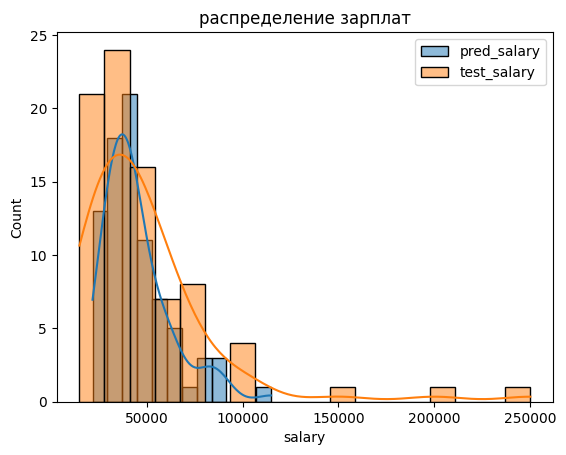

In [ ]:
sns.histplot(y_pred, label="pred_salary", kde=True)
sns.histplot(y_test, label="test_salary", kde=True).set(title = 'распределение зарплат')
plt.legend()

## B - Сделайте выводы о том какие факторы обладают наибольшим влиянием на уровень зарплаты

In [ ]:
result = permutation_importance(
    rf, X_train, y_train, n_repeats=30, random_state=42
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

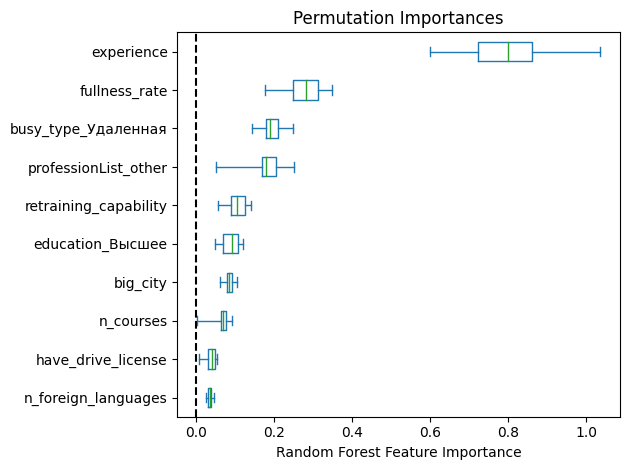

In [ ]:
slice_importances = importances.iloc[:,-10:]
ax = slice_importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Random Forest Feature Importance")
ax.figure.tight_layout()

На уровень зарплаты больше всего оказывает влиние:
* стаж работы
* fullnes_rate
* удаленная ли работа
* тип профессии, в данном случае из группы 'остальные'
* кандидат из большого города
* переобучаемость
